# Problem 1


As you can see, `gensim` provides an object that can be keyed with a given word to return the word vector. We loaded the `glove-wiki-gigaword-100` word vectors, which were trained on the combination of the Gigaword and Wikipedia datasets using the GloVe algorithm, and are 100-dimensional word vectors.

For this problem, you should
1. Implement a function that computes the average of the word vectors for a given sentence.
2. Get the average word vectors for every sentence in the training and test sets.
3. Train a logistic regression model to predict the sentiment label (0 or 1) using the average word vectors as input.
4. Evaluate its performance on the test set.

You are welcome to use whatever approach/framework you want to build and train the logistic regression model. The textbook has an example implementation that you can use [here](http://d2l.ai/chapter_linear-networks/softmax-regression-concise.html).

Note that for the first step, you will have to handle out-of-vocabulary words in some way, since the word vector collection does not include every word in the SST-2 dataset. My simple recommendation is jsut to ignore out-of-vocabulary words completely when taking the average across word vectors for a given sentence.

After training a reasonable model on `glove-wiki-gigaword-100`, try a different set of word vectors than the `glove-wiki-gigaword-100` model. You can find a list of available pre-trained word vectors [here](https://github.com/RaRe-Technologies/gensim-data#models). Report the difference in accuracy between the different pre-trained word vectors and make a guess as to why one works better or worse than the other.

In [1]:
import numpy as np
import random
import time
from d2l import torch as d2l

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


import torch.utils.data as data_utils

import unicodedata as uni
import gensim.downloader as api

import warnings
warnings.filterwarnings('ignore')

seedy = 666
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device available for running: %s" % device)

Device available for running: cuda:0


In [2]:
def load_sst2_data(filename):
    with open(filename) as f:
        data = [(l[2:].strip(), int(l[0])) for l in f.readlines()]
    return tuple(zip(*data))

sentences_train, labels_train = load_sst2_data("stsa.binary.train.txt")
sentences_test, labels_test = load_sst2_data("stsa.binary.test.txt")

# 6290 training samples
# 1821 test samples

In [3]:
word_vectors = api.load("glove-wiki-gigaword-100")

In [4]:
len(word_vectors.key_to_index.keys())

400000

In [ ]:
# from gensim.utils import simple_preprocess
# Tokenize the text column to get the new column 'tokenized_text'

# tokenizes_train = [simple_preprocess(line, deacc=True) for line in top_data_df_small['text']] 
# print(top_data_df_small['tokenized_text'].head(10))

In [5]:
def get_avg_vec(sentence):
    clean_sentence = uni.normalize("NFKD", sentence).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    words = "".join([x.lower() for x in clean_sentence.split(" ")])
    try:
        vecs = [word_vectors.get_vector(x) for x in words]
    except Exception as e:
        print(e, sentence)
        
    vec_array = np.vstack(vecs)
#     print(vec_array.shape)
    avg_vec = np.mean(vec_array,axis=0)
    return avg_vec

In [124]:
def get_avg_vec(sentence):
    clean_sentence = uni.normalize("NFKD", sentence).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    words = [x.lower() for x in clean_sentence.split(" ") if x.lower() in word_vectors.key_to_index.keys()]


    try:
        vecs = [word_vectors.get_vector(x) for x in words]
#         print(len(vecs))
    except Exception as e:
        print(e, sentence)
        
    vec_array = np.vstack(vecs)
    avg_vec = np.mean(vec_array,axis=0)
    return avg_vec

In [125]:
test = ["Did anyone run into an issue where their loss was", "really decreasing using the full BERT model"]

poo = [get_avg_vec(x) for x in test]
poo[0].shape

10
7


(100,)

In [126]:
_X_train = np.array([get_avg_vec(x) for x in sentences_train])


17
11
35
20
13
19
17
13
25
6
16
19
19
12
14
18
18
24
10
18
21
6
20
39
30
23
22
3
16
7
27
4
9
10
7
7
22
25
17
10
7
16
18
25
22
9
10
28
27
3
12
38
16
8
13
5
32
13
34
25
23
12
16
39
25
31
11
19
21
25
15
6
30
22
19
7
23
30
26
16
5
31
15
16
6
12
25
12
10
9
27
14
14
17
20
6
16
34
8
10
11
17
14
23
2
8
18
23
37
8
15
27
10
7
23
16
13
23
23
22
12
9
28
27
18
17
22
17
19
25
10
9
7
10
13
29
20
25
17
6
8
6
23
23
28
25
37
10
6
19
23
8
22
17
28
24
18
20
17
29
14
20
23
13
40
22
23
11
26
6
20
9
9
21
22
12
11
13
16
21
24
11
40
23
16
24
24
23
23
19
9
24
16
33
17
13
23
26
22
10
20
12
29
10
19
10
22
31
33
27
18
11
25
21
5
17
31
27
14
32
31
18
29
28
14
38
22
14
35
9
29
21
21
24
33
21
31
22
20
12
19
22
36
21
7
13
15
40
8
21
39
19
31
11
9
24
6
6
32
35
27
28
22
9
6
8
18
35
23
19
28
31
11
23
24
14
19
16
13
10
17
18
27
18
16
30
14
10
35
21
16
29
3
12
25
7
8
19
36
7
13
21
8
25
28
17
8
22
22
14
25
31
22
15
21
16
43
14
20
13
19
14
12
12
10
26
19
16
14
20
25
28
24
24
11
2
33
14
4
12
15
24
10
34
17
22
21
11
8
20
31
22

15
12
7
23
31
13
17
24
14
29
29
30
19
20
34
22
26
27
13
17
17
15
7
6
15
32
14
2
32
16
7
17
13
25
24
24
19
30
26
19
36
35
3
25
26
39
6
28
12
19
20
24
27
27
49
19
5
18
7
14
17
25
6
28
38
6
8
11
23
9
19
10
10
19
11
10
17
30
30
36
12
10
25
29
28
15
35
37
5
25
13
21
7
13
18
15
33
8
18
23
16
7
5
7
34
22
23
19
21
31
21
17
13
26
11
19
22
19
5
15
25
19
12
9
45
22
33
26
15
23
6
22
31
30
28
16
7
15
16
11
29
4
13
15
16
12
22
24
16
17
22
12
11
17
25
20
13
18
9
8
30
12
14
13
7
9
9
17
33
31
10
15
13
3
15
23
23
15
15
24
29
24
15
15
10
19
30
11
19
12
19
24
24
18
10
37
6
18
17
28
7
22
8
35
5
29
28
8
8
10
28
7
13
16
26
18
6
14
9
12
19
15
25
12
34
30
19
22
22
22
20
16
16
7
25
4
10
32
21
24
19
33
16
19
9
25
22
27
19
9
32
18
9
5
4
8
21
15
23
28
28
10
23
22
20
30
20
32
16
18
16
12
10
9
15
9
21
9
19
13
13
38
40
26
35
22
18
22
3
13
14
28
24
31
26
17
20
22
18
16
14
7
23
38
31
15
14
12
27
14
4
27
20
6
13
24
24
47
16
15
36
22
18
12
27
20
8
11
24
24
18
12
12
24
6
24
23
14
18
10
23
20
13
36
24
12
24
25
28
9
32
15
1

26
21
24
14
5
17
27
20
18
10
30
14
12
6
20
7
31
34
25
5
11
18
12
12
18
13
24
33
12
15
14
8
18
15
22
3
17
33
17
16
18
31
5
20
4
23
7
19
19
11
23
17
22
6
35
24
20
24
24
26
11
27
16
25
17
52
9
21
11
32
28
15
23
35
26
27
15
25
34
19
17
13
20
9
21
17
21
12
35
9
16
6
11
31
27
27
13
25
15
36
21
3
19
16
17
23
25
18
21
32
21
3
8
15
18
31
37
4
9
13
13
29
12
35
18
29
14
5
28
14
4
32
11
33
6
25
30
24
28
40
18
10
17
27
19
24
23
29
18
11
30
42
32
25
24
16
26
9
17
14
29
4
34
25
21
17
27
6
27
20
22
2
4
9
15
19
7
33
15
13
33
23
18
19
18
43
8
3
13
11
24
20
25
7
26
33
14
26
15
9
36
9
25
21
15
5
21
27
34
19
24
3
32
22
17
32
14
17
10
8
12
46
12
20
11
22
20
28
15
18
25
21
27
17
13
23
32
18
22
12
28
40
14
4
22
13
22
15
47
42
28
14
15
17
27
10
16
4
36
18
5
21
36
26
15
11
7
23
15
27
8
32
30
22
11
27
19
6
17
35
22
5
42
23
10
8
5
15
17
10
11
19
28
17
8
21
26
21
6
26
33
33
42
17
10
18
18
9
27
4
20
24
18
18
19
35
14
19
14
13
14
7
9
12
21
20
17
5
5
31
9
38
16
36
21
15
44
34
15
8
8
21
28
31
9
18
9
5
26
14
20
11
8
15

In [127]:
s = time.time()
_X_train = np.array([get_avg_vec(x) for x in sentences_train])
_X_test = np.array([get_avg_vec(x) for x in sentences_test])

_y_train = np.array(list(labels_train))
_y_test = np.array(list(labels_test))

print("Shapes:",_X_train.shape, _y_train.shape)

17
11
35
20
13
19
17
13
25
6
16
19
19
12
14
18
18
24
10
18
21
6
20
39
30
23
22
3
16
7
27
4
9
10
7
7
22
25
17
10
7
16
18
25
22
9
10
28
27
3
12
38
16
8
13
5
32
13
34
25
23
12
16
39
25
31
11
19
21
25
15
6
30
22
19
7
23
30
26
16
5
31
15
16
6
12
25
12
10
9
27
14
14
17
20
6
16
34
8
10
11
17
14
23
2
8
18
23
37
8
15
27
10
7
23
16
13
23
23
22
12
9
28
27
18
17
22
17
19
25
10
9
7
10
13
29
20
25
17
6
8
6
23
23
28
25
37
10
6
19
23
8
22
17
28
24
18
20
17
29
14
20
23
13
40
22
23
11
26
6
20
9
9
21
22
12
11
13
16
21
24
11
40
23
16
24
24
23
23
19
9
24
16
33
17
13
23
26
22
10
20
12
29
10
19
10
22
31
33
27
18
11
25
21
5
17
31
27
14
32
31
18
29
28
14
38
22
14
35
9
29
21
21
24
33
21
31
22
20
12
19
22
36
21
7
13
15
40
8
21
39
19
31
11
9
24
6
6
32
35
27
28
22
9
6
8
18
35
23
19
28
31
11
23
24
14
19
16
13
10
17
18
27
18
16
30
14
10
35
21
16
29
3
12
25
7
8
19
36
7
13
21
8
25
28
17
8
22
22
14
25
31
22
15
21
16
43
14
20
13
19
14
12
12
10
26
19
16
14
20
25
28
24
24
11
2
33
14
4
12
15
24
10
34
17
22
21
11
8
20
31
22

31
11
27
24
15
27
3
16
12
15
7
22
33
17
13
31
23
23
21
11
15
27
36
8
27
25
18
19
6
4
33
12
10
7
17
8
4
12
6
10
31
16
15
24
12
18
20
29
13
25
26
9
32
40
22
12
21
19
10
20
36
24
23
30
21
21
32
19
15
11
12
11
23
4
26
10
17
18
24
9
11
30
44
6
30
14
33
17
18
23
15
22
21
21
21
24
6
29
23
21
32
24
22
5
20
21
19
19
29
20
24
26
3
31
6
7
11
15
24
8
12
23
35
16
10
16
19
36
16
12
18
18
18
18
11
13
24
21
5
13
10
12
18
15
16
17
7
5
21
22
25
19
16
24
15
4
4
22
36
15
21
27
13
21
12
10
10
15
18
26
18
13
9
47
5
20
11
9
6
11
19
27
22
24
29
39
10
18
5
10
11
18
40
11
25
28
26
11
12
26
9
24
17
8
10
32
19
23
6
27
28
28
35
33
29
13
29
20
25
30
41
15
3
28
30
21
25
14
19
3
19
22
26
22
30
9
23
36
14
19
36
18
7
35
7
28
7
39
31
6
25
22
24
10
12
22
21
11
35
20
14
18
24
34
11
17
19
6
8
20
6
28
18
38
19
9
25
12
13
17
18
15
12
7
23
31
13
17
24
14
29
29
30
19
20
34
22
26
27
13
17
17
15
7
6
15
32
14
2
32
16
7
17
13
25
24
24
19
30
26
19
36
35
3
25
26
39
6
28
12
19
20
24
27
27
49
19
5
18
7
14
17
25
6
28
38
6
8
11
23
9
19


27
19
24
23
29
18
11
30
42
32
25
24
16
26
9
17
14
29
4
34
25
21
17
27
6
27
20
22
2
4
9
15
19
7
33
15
13
33
23
18
19
18
43
8
3
13
11
24
20
25
7
26
33
14
26
15
9
36
9
25
21
15
5
21
27
34
19
24
3
32
22
17
32
14
17
10
8
12
46
12
20
11
22
20
28
15
18
25
21
27
17
13
23
32
18
22
12
28
40
14
4
22
13
22
15
47
42
28
14
15
17
27
10
16
4
36
18
5
21
36
26
15
11
7
23
15
27
8
32
30
22
11
27
19
6
17
35
22
5
42
23
10
8
5
15
17
10
11
19
28
17
8
21
26
21
6
26
33
33
42
17
10
18
18
9
27
4
20
24
18
18
19
35
14
19
14
13
14
7
9
12
21
20
17
5
5
31
9
38
16
36
21
15
44
34
15
8
8
21
28
31
9
18
9
5
26
14
20
11
8
15
20
19
16
11
10
20
9
5
13
12
16
7
35
30
22
34
31
4
11
29
7
12
12
22
10
13
12
19
13
24
11
13
18
6
11
6
29
30
33
32
8
11
32
26
30
15
21
36
12
13
26
10
13
9
20
20
23
40
14
11
33
27
19
21
12
18
16
27
43
19
3
19
39
10
19
16
21
31
8
17
17
23
11
5
28
27
12
14
45
28
12
19
12
12
7
21
6
4
23
18
4
10
8
9
19
25
17
18
30
21
11
17
12
14
20
32
24
17
25
27
18
13
31
22
15
7
12
28
21
21
36
36
39
13
27
39
17
4
28
14
19
24


In [128]:
logistic_reg = LogisticRegression(solver="liblinear",random_state = seedy, max_iter=10000, n_jobs=-1)
logistic_reg.fit(X_train,y_train)

# y_test = labels_test
y_pred = logistic_reg.predict(X_test)

print("Accuracy: ",round(accuracy_score(y_test,y_pred),3))
print("F1: ",round(f1_score(y_test, y_pred),3))

Accuracy:  0.767
F1:  0.774


## <font color=blue> Try torch logistic regression.

In [97]:
y_train = torch.tensor(_y_train)
X_train = torch.tensor(_X_train)
dataset_train = data_utils.TensorDataset(X_train, y_train)

y_test = torch.tensor(_y_test)
X_test = torch.tensor(_X_test)
dataset_test = data_utils.TensorDataset(X_test, y_test)

bs = 32
loader_train = data_utils.DataLoader(dataset_train, batch_size=bs, shuffle=True, drop_last=True)
loader_test = data_utils.DataLoader(dataset_test, batch_size=bs, shuffle=True, drop_last=True)

print(y_train.shape,X_train.shape)

torch.Size([6920]) torch.Size([6920, 100])


In [98]:
y_train[:10]

tensor([1, 0, 0, 1, 1, 1, 0, 1, 0, 0])

AssertionError: 0.7030375580544825

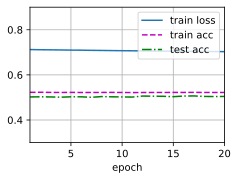

In [99]:
net = nn.Sequential(nn.Flatten(), nn.Linear(100, 2))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.1)

net.apply(init_weights)
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.00001)


my_epochs = 20
d2l.train_ch3(net, loader_train, loader_test, loss, my_epochs, trainer)

In [ ]:
train_loader = DataLoader(train_ds, my_batch, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, my_batch*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(testset, my_batch*2, num_workers=4, pin_memory=True)

In [ ]:
def train_model(train_loader, val_loader, model, optimizer, batch_size, num_epochs, stopper='loss'):
    
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    
    running = - math.inf
    current = running
    
    best_run = 0
    best_model = copy.deepcopy(model.state_dict())
    
    for epoch in tqdm_notebook(range(num_epochs), total=num_epochs):
#         scheduler.step()
        print("Epoch",epoch+1)
        
        for phase in ['train','validate']:
            running_loss = 0.0
            running_acc = 0.0
            
            if phase=='train':
                loader = train_loader
                model.train()
            else:
                loader = val_loader
                model.eval()
                
#             for inputs,labels in tqdm_notebook(loader, total=len(loader)):
            for inputs,labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    if phase=='train':
                        loss.backward()                        
                        optimizer.step()
                running_loss += loss.item()

                y_test = np.asarray(labels.cpu())
                y_score = outputs.cpu().detach().numpy()
                y_pred = np.argmax(y_score,axis=1)

                acc = accuracy_score(y_test,y_pred)
                running_acc += acc
            
            loss = running_loss / len(loader) 
            acc =  running_acc / len(loader) 
            
            if phase=='train':
                train_loss.append(loss)
                train_acc.append(acc)
                
            elif phase=='validate':
                val_loss.append(loss)
                val_acc.append(acc)
                
                if stopper=='loss':
                    current = -loss
                elif stopper=='acc':
                    current = acc
                if current >= running:
                    running = current
                    best_run = epoch+1
                    best_model = copy.deepcopy(model.state_dict()) 
                
            print("~ %s LOSS: %5.3f | ACC: %5.3f" % (phase,loss,acc))
            if current >= running and phase=='validate':
                print("      BEST SO FAR ^ ^ ^")
        
    return (best_run, best_model, train_loss, train_acc, val_loss, val_acc)

In [ ]:
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# Problem 2

In this problem, instead of representing each sentence as an average of the word vectors for the words in the sentence, you will get sentence vectors from a pre-trained BERT model. `gluonnlp` provides a handy interface for loading a pre-trained BERT model, check it out [here](https://nlp.gluon.ai/model_zoo/bert/index.html). A popular choice for a `pytorch` implementation is [Hugging Face Transformers](https://huggingface.co/transformers/). I would recommend using the DistilBERT model (called `distil_book_corpus_wiki_en_uncased` in `gluonnlp` and `distilbert-base-uncased` in Hugging Face `transformers`). DistilBERT is a smaller (and more computationally efficienty) version of BERT that gets reasonable performance. In this problem, you will use BERT in two ways: Either to get fixed sentence representations for each sentence, or via fine-tuning the full model (as is most common in transfer learning).

1. Replace the average-word-vector representation you used from the first problem with the CLS token representation for each sentence from DistilBERT. Then, train a small logistic regressor on top of these new vector representations and retport the performance.
2. Fine-tune all of BERT's parameters on the SST-2 dataset. [Here](https://nlp.gluon.ai/examples/sentence_embedding/bert.html) is a tutorial for `gluonnlp`, [here](https://huggingface.co/transformers/training.html) is one for `transformers`. Note that you may need to modify the tutorial code somewhat (for example, the `gluonnlp` example focuses on sentence-pair classification rather than sentence classification).

Which worked better? Note that [state-of-the-art performance](https://gluebenchmark.com/leaderboard) on SST-2 is about 98%, and BERT's reported performance is about 95%. How close are you?

In [ ]:
from transformers import DistilBertTokenizerFast
from transformers import AdamW
from transformers import DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

import torch.utils.data as data_utils


In [ ]:
from transformers import BertTokenizer

In [ ]:
from transformers import BertForSequenceClassification

In [ ]:
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=1e-5)

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained(LIL_BERT, cls_token='[CLS]')

encodings_train = tokenizer(list(sentences_train), truncation=True, padding=True, return_tensors='pt')
encodings_test = tokenizer(list(sentences_test), truncation=True, padding=True, return_tensors='pt')

dataset_train = MyDataset(encodings_train, labels_train)
dataset_test = MyDataset(encodings_test, labels_test)

In [ ]:
train_dataset

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=dataset_train,         # training dataset
    eval_dataset=dataset_test             # evaluation dataset
)

trainer.train()

In [ ]:
res = trainer.evaluate()

In [ ]:
res

In [ ]:
pred = trainer.predict(dataset_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

print(compute_metrics(pred))

In [ ]:
X_train = encodings_train['input_ids'].to(device)
y_train = torch.tensor(labels_train)
dataset_train = data_utils.TensorDataset(X_train, y_train)

X_test = encodings_test['input_ids'].to(device)
y_test = torch.tensor(labels_test)
dataset_test = data_utils.TensorDataset(X_test, y_test)

In [ ]:
# from transformers import BertTokenizer, glue_convert_examples_to_features
# data = tfds.load('glue/mrpc')

# train_dataset = glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, task='mrpc')

In [ ]:
train_dataset